In [1]:
try:
    import relax
except ImportError:
    import sys; sys.path.append("..")

from relax import Trainer, TrainingConfig
from relax.models import VQVAE
from relax.utils import filter_params

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import jax
import optax
import haiku as hk
import numpy as np
import jax.numpy as jnp

import tensorflow_datasets as tfds

from dataclasses import dataclass
from typing import Tuple, Sequence, Optional

def ds_to_array(ds):
    itr = (
            ds
            .map(lambda d: d['image'] / 255)
            .as_numpy_iterator()
            )
    return jax.device_put(list(itr))

2022-10-30 19:38:50.441786: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-30 19:38:51.061894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu
2022-10-30 19:38:51.061993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu
2022-10-30 19:38:51.061999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, 

Let's import the dataset and turn it to a *jnp.ndarray*
---

In [2]:
train_ds, test_ds = tfds.load("mnist", split=["train[:80%]", "test"], batch_size=128)
x = ds_to_array(train_ds)
x_test = ds_to_array(test_ds)

Now we can declare the convolutional *Encoder* and *Decoder* 
---

In [3]:
@dataclass
class Encoder(hk.Module):
    latent_dim : int
    conv_dim : int = 32

    def __call__(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        x = hk.Conv2D(self.conv_dim, kernel_shape=(3, 3), stride=2)(x)
        x = jax.nn.relu(x)
        x = hk.Conv2D(2*self.conv_dim, kernel_shape=(3, 3), stride=2)(x)
        x = jax.nn.relu(x)
        x = hk.Flatten()(x)

        μ = hk.Linear(self.latent_dim)(x)
        logvar = hk.Linear(self.latent_dim)(x)
        
        return μ, logvar

@dataclass
class Decoder(hk.Module):
    output_shape : Sequence[int]
    conv_dim : int = 32

    def __call__(self, z : jnp.ndarray) -> jnp.ndarray:
        
        w, h, _ = self.output_shape
        reshaped = (w//4, h//4, 32)
        z = hk.Linear(np.prod(reshaped))(z)
        z = jnp.reshape(z, (-1, *reshaped))

        z = hk.Conv2DTranspose(2*self.conv_dim, kernel_shape=(3, 3), stride=2)(z)
        z = jax.nn.relu(z)
        z = hk.Conv2DTranspose(self.conv_dim, kernel_shape=(3, 3), stride=2)(z)
        z = jax.nn.relu(z)
        logits = hk.Conv2DTranspose(1, kernel_shape=(3, 3), stride=1)(z)

        return logits

@hk.transform
def model(x):
    encoder=Encoder(latent_dim=128)
    decoder=Decoder(output_shape=(28, 28, 1))
    vqvae = VQVAE(
            encoder=encoder,
            decoder=decoder,
            embedding_dim=encoder.latent_dim,
            num_embeddings=256,
            β=0.25
    )
    return vqvae(x)


@jax.jit
def loss_fn(params, rng, data) -> jnp.ndarray:
    def mse(data, logits):
        return jnp.mean(jnp.square(data - logits))
    results = model.apply(params, rng, data)
    bloss = results.vq_results.loss + mse(data, results.logits)
    return bloss

We can now setup the Trainer to run for *20* epochs with our *loss_fn*
---

In [4]:
config = TrainingConfig(
            epochs=25,
            )
optimizer = optax.adam(0.001)

trainer = Trainer(model, optimizer, config)

rng = jax.random.PRNGKey(42)
fake_input = jnp.zeros((1, 28, 28, 1))
init_state = trainer.init(rng, fake_input)

In [5]:
trained_state = trainer.train(init_state, loss_fn, x, jit_update_step=True)

Training:   0%|          | 0/25 [00:00<?, ?epoch/s]

Inference
---

Once trained, we can see how well the latent distribution *z* can be used to output new images

In [6]:
def encode(params, x, latent_dim=128):
    _, apply = hk.without_apply_rng(hk.transform(lambda x: Encoder(latent_dim=latent_dim)(x)))
    encoder_params = filter_params("encoder", params)
    return apply(encoder_params, x)

def decode(params, z, output_shape=(28, 28, 1)):
    _, apply = hk.without_apply_rng(hk.transform(lambda z: Decoder(output_shape=output_shape)(z)))
    decoder_params = filter_params("decoder", params)
    return apply(decoder_params, z)

Let's plot the walk in the latent space for 2 images
---

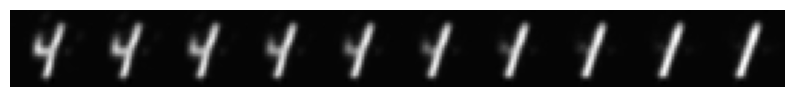

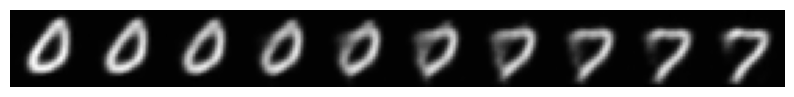

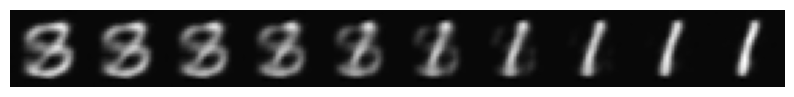

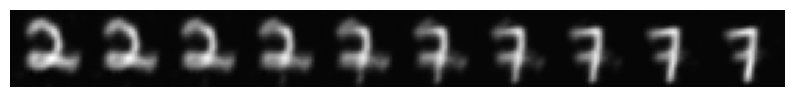

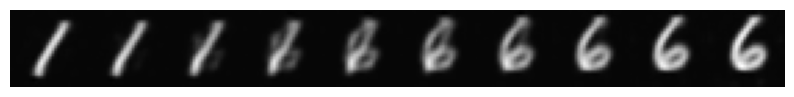

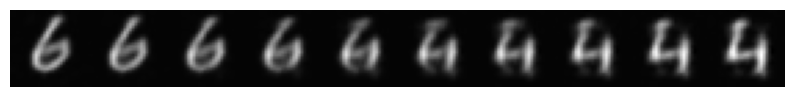

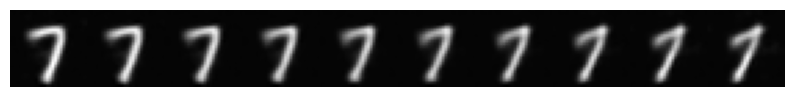

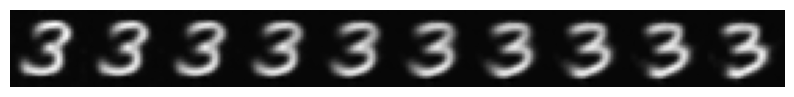

In [7]:
import einops
import matplotlib.pyplot as plt

def plot_latent_walking(params, x1, x2, rng, n_steps=10):
    μ, logvar = encode(params, jnp.stack([x1, x2]))
    z1, z2 = μ + jnp.exp(0.5 * logvar) * jax.random.normal(rng, μ.shape)
    Δ = z2 - z1
    z_walk = jnp.stack([z1 + α * Δ for α in jnp.linspace(0, 1, n_steps)])
    x_walk = decode(params, z_walk)
    
    plt.figure(figsize=(10, 20))
    plt.imshow(einops.rearrange(x_walk, 'b w1 w2 c -> w1 (b w2) c'), cmap="gray")
    plt.axis('off')
    plt.show()

for examples in einops.rearrange(x[0], '(b s) ... -> b s ...', s=2)[:8]:
    plot_latent_walking(trained_state.params, *examples, jax.random.PRNGKey(1))